<a href="https://colab.research.google.com/github/alert-geomaterials/2023-doctoral-school/blob/main/lectures/hands-on/L07%2608%20-%20FG_ANN-basic/ALERT2023_handson_Ch7_8_Exo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ALERT 2023**

## **Artificial Neural Networks - Chapters 7 and 8**


Author: Filippo Gatti

### Disclaimer

This hands-on notebook is devoted to **artificial Neural Networks** ($\mathcal{NN}$) and it covers chapters 7 and 8.

In the following, the code cells introduced by a tag **[TODO]** are meant to be completed by you!

In [ ]:
# basic packages
from IPython.display import Image
import numpy as np
import scipy
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib.colors import ListedColormap

# This is required only for notebooks
%matplotlib inline

np.random.seed(0)

# **Exercise** Design a deep $\mathcal{LSTM}$-based network to predict earthquake structural response (see Section 2.8, Chapter 7)

## **Quick facts**

- $\mathcal{LSTM}$ are widely  used to predict the non-linear transient dynamics of complex physical systems

- $\mathcal{LSTM}$ are powerful input/output surrogate models of the system dynamics, especially if compared with traditional linear and non-linear regressions methods for time-series forcast, such as ARMA, ARIMA, NARMAX etc. Therefore, $\mathcal{LSTM}$ are largely used to identify complex system's time evolution, based on an external excitation (the $\mathcal{LSTM}$ input)

- Once trained, $\mathcal{LSTM}$ surrogate cumbersome numerical simulations (such as Finite Element Analysis) since they intrisically learn the system non-linear dynamics and enable the user with a reliable forecast tool

- In physics, the traditional dynamic system time evolution is often encapsulated into a second-order Ordinary Differential Equation (ODE) obtained after discretization of the underlying continuous problem. For instance, calling  $\mathbf{y}(t)\subset \mathbb{R}^{p}$ the transient dynamic response of a $p$ Degrees-of-Freedom (DoF) system $\mathcal{M}$ under dynamic inertial load $\mathbf{\ddot x}(t)$ (the dots stand for time derivative), can be encapsulated in the following vector equation:

$$ \mathbf{M}\mathbf{\ddot y}(t)+\mathbf{C}\mathbf{\dot y}(t)+\mathbf{F}(\mathbf{y}(t),\mathbf{\dot y}(t))=- \mathbf{M}\mathbf{\Gamma}\ddot x(t)$$

with $\mathbf{M}$ and $\mathbf{C}$ the mass and damping matrices, $\mathbf{F}(\mathbf{y}(t),\mathbf{\dot y}(t))$ the non-linear restoring force vector and $\mathbf{\Gamma}$ the vector of the participation factor.

- A nice kindergarten $\mathcal{LSTM}$ application to predict the non-linear dynamics of a second-order ODE is provided by [1]. The authors solved the non-linear 5-DoF ($p$=5) dynamic equation adopting the  Bouc-Wen model for restoring forces, obtained by solving the following ODE:

$$\dot f_i(t)=k_i\cdot \left(\dot y_{i+1}(t)-\dot y_i(t)\right)-\alpha_i\cdot\vert \dot y_{i+1}(t)-\dot y_i(t) \vert \cdot \vert f_i(t) \vert ^{n_i-1}\cdot f_i(t) -\beta_i\cdot \left(\dot y_{i+1}(t)-\dot y_i(t)\right)\cdot \vert f_i(t) \vert ^{n_i}, i=1,\ldots,p$$

with the following details:

-- Fixed base: $ y_0(t)=0$

-- $k_i$ stiffness of the $i^{\text{th}}$ DoF (interstorey stiffness between $i+1^{\text{th}}$ and $i^{\text{th}}$ storey)

-- Masses: $m_1$=100 kg, $m_2$= $m_3$=$m_4$=$m_5$=80 kg

-- Damping coefficients: $c_1$=$c_3$=$c_5$=0.55 kNs/m and $c_2$=$c_4$=0.5 kNs/m

-- Interstorey stiffness coefficients: $k_1$=$k_3$=$k_5$=30 kN/m and $k_2$=$k_4$=24 kN/m

-- $\alpha_i$, $\beta_i$, $n_i$ are the Bouc-Wen non-linear model parameters:
  --- $\alpha_1$=$\alpha_3$=$\alpha_5$=1 and $\alpha_2$=$\alpha_4$=2

  --- $\beta_1$=$\beta_3$=$\beta_5$=2 and $\beta_2$=$\beta_4$=1

  --- $n_1$=$n_3$=$n_5$=3 and $n_2$=$n_4$=2

-- The natural frequencies of the system are:  0.83 Hz, 2.39 Hz, 3.74 Hz, 4.80 Hz, and 5.57 Hz

- Data from Bouc-Wen non-linear 5-DoF oscillators can be downloaded here https://www.dropbox.com/sh/xyh9595l79fbaer/AACxiLyKQTAXkujrVSeqsdUsa/data_BoucWen.mat?dl=0

- The dataset contains $N$=50  input ground motion accelerations $\ddot x^{(j)}(t)\subset\mathbb{R}$, correspond to random band-limited white noise  ground motion sequences
with different magnitudes, as long as the corresponding interstorey drift $\mathbf{\Delta y}^{(j)}(t)\subset\mathbb{R}^p$. The input ground motions.

- 37 isntances are used for training (with relative indices) and 13 for testing  the deep $\mathcal{LSTM}$ model defined in the following

- Moreover, the dataset contains $N_n$=50 samples which are assumed as unknown dataset for testing the predictability performance of the trained model


## *Bibliography*
[1] Zhang, R.; Chen, Z.; Chen, S.; Zheng, J.; Büyüköztürk, O.; Sun, H. Deep Long Short-Term Memory Networks for Nonlinear Structural Seismic Response Prediction. Computers & Structures 2019, 220, 55-68. https://doi.org/10.1016/j.compstruc.2019.05.006.

[2] Zhang, R.; Phillips, B. M.; Taniguchi, S.; Ikenaga, M.; Ikago, K. Shake Table Real‐time Hybrid Simulation Techniques for the Performance Evaluation of Buildings with Inter-story Isolation. Struct. Control Health Monit. 2017, 24 (10). https://doi.org/10.1002/stc.1971.

[3] Wen, Y.-K. Method for Random Vibration of Hysteretic Systems. Journal of the Engineering Mechanics Division 1976, 102 (2), 249-263. https://doi.org/10.1061/JMCEA3.0002106.

## **Questions**

- Can you reproduce the 5-DoF response with a deep $\mathcal{LSTM}$ model?

- How many $\mathcal{LSTM}$ layers should be considered?

- Is it reasonable to stack one or more $\mathcal{MLP}$ at the top of the $\mathcal{LSTM}$ layer(s)? Why?

## **Learning Outcomes**

- Learn how to design a deep $\mathcal{LSTM}$ to predit the dynamic response of $p$-DoF

- Learn how to combine $\mathcal{LSTM}$ and $\mathcal{MLP}$ layers to connect the $\mathcal{LSTM}$ layers to the target output layer and thus construct the desired
number of output features.

## **Objective**

In the following, you are asked to conceive a deep $\mathcal{LSTM}$ network and train it on the database provided by [1] (described above), referring to the seismic response (inter-storey drift, output of the network) of a 5-DoF Bouc-Wen non-linear multi-storey building under earthquake ground motion acceleration (input of the network).

## - Step 1: Download the database provided by [1] and parse it

In [ ]:
!wget -O data_BoucWen.mat https://www.dropbox.com/sh/xyh9595l79fbaer/AACxiLyKQTAXkujrVSeqsdUsa/data_BoucWen.mat?dl=0

--2023-08-30 14:16:45--  https://www.dropbox.com/sh/xyh9595l79fbaer/AACxiLyKQTAXkujrVSeqsdUsa/data_BoucWen.mat?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/xyh9595l79fbaer/AACxiLyKQTAXkujrVSeqsdUsa/data_BoucWen.mat [following]
--2023-08-30 14:16:46--  https://www.dropbox.com/sh/raw/xyh9595l79fbaer/AACxiLyKQTAXkujrVSeqsdUsa/data_BoucWen.mat
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb1d77c7715961f78b917013140.dl.dropboxusercontent.com/cd/0/inline/CCwBCxvyS1Pt8CdaGb0MT6wDMqnheOYucAa7J_azPqQDA3UC78HtmRD0jk_z8_BnYTwMk3ewjpMHlqdvidm37TMiG8LlXM3cI_Ws0RRbJcwMGuao6G6e6PZKCZdKMumYeL2DRVaGO3__5d6Nt8_qztVC/file# [following]
--2023-08-30 14:16:47--  https://ucb1d77c7715961f78b917013140.dl.dropboxusercontent.com/cd/0/inline/C

In [ ]:
# Load data
import scipy.io
data = scipy.io.loadmat('data_BoucWen.mat')

# Training/Testing data
X = data['input_tf']  # input ground motion acceleration
y = data['target_tf'] # 5 inter-storey drifts

# Unknown data
X_pred = data['input_pred_tf'] # input ground motion acceleration
y_pred_ref = data['target_pred_tf'] # 5 inter-storey drifts

# Training/testing indices
train_indices = data['trainInd'] - 1 # indices for train set
test_indices = data['valInd'] - 1 # indices for test set

# Number of samples N, number of time steps nt, number of
(N, nt, p) = y.shape

## - Step 2 **[TODO]**: Scale and subsample (factor 10) the database. Split `torch` tensors in train/test databases

*Note*: use the same scaler for `X` and `X_pred` and the same scaler for `y` and `y_pred`

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
torch.manual_seed(0)

# Subsampling factor
ss = 10

# Scale data X
X = X.flatten()[:,np.newaxis]
Xscaler = MinMaxScaler(feature_range=(-1, 1))
Xscaler.fit(X)
Xs = Xscaler.transform(X)
Xs = np.reshape(Xs, [N, nt, 1])[:,0::ss,:]

# Scale data y
y = np.reshape(y, [N*nt, p])
yscaler = MinMaxScaler(feature_range=(-1, 1))
yscaler.fit(y)
ys = yscaler.transform(y)
ys = np.reshape(ys, [N, nt, p])[:,0::ss,:]

# Scale data X predicted
X_pred = X_pred.flatten()[:,np.newaxis]
Xs_pred = Xscaler.transform(X_pred)
Xs_pred = np.reshape(Xs_pred, [N, nt, 1])[:,0::ss,:]

# Scale data y predicted
y_pred = np.reshape(y_pred_ref, [N*nt, p])
ys_pred = yscaler.transform(y_pred)
ys_pred = np.reshape(ys_pred, [N, nt, p])[:,0::ss,:]

# Train dataset
X_train = torch.tensor(Xs[0:len(train_indices[0]),:]).to(torch.float32)
y_train = torch.tensor(ys[0:len(train_indices[0]),:,:]).to(torch.float32)

# Test dataset
X_test = torch.tensor(Xs[len(train_indices[0]):,:]).to(torch.float32)
y_test = torch.tensor(ys[len(train_indices[0]):,:,:]).to(torch.float32)

# Train dataset
X_train = torch.tensor(Xs[0:len(train_indices[0]),:]).to(torch.float32)
y_train = torch.tensor(ys[0:len(train_indices[0]),:,:]).to(torch.float32)

# Prediction dataset
X_pred = torch.tensor(Xs_pred).to(torch.float32)
y_pred = torch.tensor(ys_pred).to(torch.float32)

Text(0.5, 1.0, 'Input ground motion')

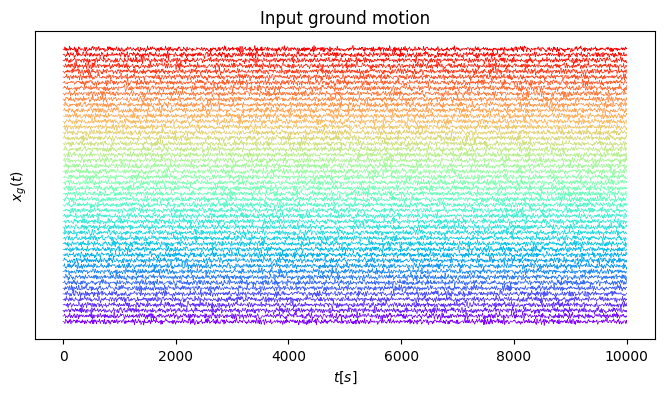

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

colors = cm.rainbow(np.linspace(0, 1, data["input_tf"].shape[0]))
for i, (yp, c) in enumerate(zip(data["input_tf"], colors)):
    ax.plot(yp/20+i, linewidth=0.5, color=c)
ax.set_xlabel("$t [s]$")
ax.set_ylabel(r"$x_g(t)$")
ax.set_yticks([])
ax.set_title('Input ground motion')

In [ ]:
colors = cm.rainbow(np.linspace(0, 1, data["target_tf"].shape[0]))

for p in range(data["target_tf"].shape[-1]):
    fig, ax = plt.subplots(figsize=(8,8))
    for i, (yp, c) in enumerate(zip(data["target_tf"][:,:,p], colors)):
        ax.plot(yp+i/10, linewidth=0.5, color=c)
    ax.set_xlabel("$t [s]$")
    ax.set_ylabel(r"$x_g(t)$")
    ax.set_yticks([])
    ax.set_title(r"$y_{{{:d}}}$".format(p+1))

Output hidden; open in https://colab.research.google.com to view.

# - Step 3 **[TODO]**: design a deep $\mathcal{LSTM}$

See the `pytorch` documentation https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

The final $\mathcal{NN]}$ should consist in:

-- one initial `nn.LSTM` with  $fan\_out$=50 with `nn.ReLU` activation function

-- one second `nn.LSTM` with $fan\_out$=50 with `nn.ReLU`activation function

-- two `Linear` layers with $fan\_in=fan\_out$=50

-- 20% dropout in the `nn.LSTM` layers

*Hint*: Design the custom deep $\mathcal{LSTM}$ network by defining a subclass of `torch.nn.Module` class, in order to customize its `forward` method

*Note*:
the `pytorch` $\mathcal{LSTM}$ implementation (`LSTM`) takes as input a time history tensor `X` with shape $t, f$, whre $t$ indicates the time length and $f$ the number of features.

The first $\mathcal{LSTM}$ takes all the $N$ training time histories $\ddot{x}^{(j)}(t)$ input ground motion accelerations, sampled at $nt$ time-steps, stacked and stored in the `X_train` variable, whose shape is `X_train.shape`=$[N,nt,1]$. In this case, do not forget to use the option `batch_first=True`

*Note*:
the `pytorch` $\mathcal{LSTM}$ implementation (`LSTM`) outputs the hidden state $\mathbf{h}(t)$, whose time size $fan\_out$ corresponds to the input variable `hidden_size`. Moreover, `LSTM` provides the last update of the cell and hidden state $\mathbf{c}(t_{fan\_out})$, $\mathbf{h}(t_{fan\_out})$. Therefore,  `nn.LSTM` cannot used in the `nn.Sequential` wrapper.

*Note*:
the full hidden state outputted by the first `LSTM` layer is the input of the second `LSTM`

In [ ]:
'''[TODO] Design a custom deep LSTM model'''
from torch import nn
fan_out1 = 50
fan_out2 = 50
Nl = 2

class CustomLSTM(nn.Module):
    def __init__(self, fan_outs, out_features):
        super().__init__()

        # 1st layer LSTM
        self.lstm1 = nn.LSTM(input_size=1,
            hidden_size=fan_outs[0],
            num_layers=1,
            batch_first=True,
            dropout=0.0)

        # 2nd LSTM layer
        self.lstm2 = nn.LSTM(input_size=fan_outs[0],
            hidden_size=fan_outs[1],
            num_layers=1,
            batch_first=True,
            dropout=0.0)

        # 1st layer MLP
        self.mlp1 = nn.Linear(in_features = fan_outs[1],
                              out_features =fan_outs[1])
        # 2nd layer MLP
        self.mlp2 = nn.Linear(in_features =fan_outs[1],
                            out_features = out_features)

    def forward(self, x):
        h1, (hn1, cn1) = self.lstm1(x)  # lstm (1)
        h1 = nn.functional.relu(h1) # relu (1)
        h1 = nn.functional.dropout(h1)
        h2, (hn2, cn2)=self.lstm2(h1)  # lstm (2)
        h2 = nn.functional.relu(h2) # relu (2)
        h2 = nn.functional.dropout(h2)
        h3 = self.mlp1(h2) # linear+relu (1)
        y = self.mlp2(h3) # final output layer
        return y

h_theta = CustomLSTM([fan_out1, fan_out2], out_features=5)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


## - Step 4: choose the optimization scheme

In [ ]:
'''Optimization setup'''
# Define the loss function
loss_fn = nn.MSELoss()

# number of epochs
n_e = 500

# batch size and batch per epochs
batch_size = 10
batches_per_epoch = len(X_train) // batch_size

# Optimizer
learning_rate = 0.001
beta1 = 0.9 # Adam coefficients
beta2 = 0.999 # Adam coefficients
epsilon = 1e-6 # tolerance
optimizer = torch.optim.AdamW(h_theta.parameters(),
                             lr=learning_rate,
                             betas=(beta1, beta2),
                             eps=epsilon)

## - Step 5 **[TODO]** train the deep $\mathcal{NN}$

In [ ]:
'''[TODO] Train the NN'''
import tqdm
train_loss_hist = []
test_loss_hist = []
for epoch in range(n_e):
    epoch_loss = []
    # set model in training mode
    h_theta.train()

    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size,:,:]
            y_batch = y_train[start:start+batch_size,:,:]
            idx = torch.randperm(X_batch.shape[0])
            X_batch = X_batch[idx,:,:]
            y_batch = y_batch[idx,:,:]
            # infer (forward)
            y_pred = h_theta(X_batch)
            # compute the loss
            loss = loss_fn(y_pred, y_batch)
            # reset previously saved gradients and empty the optimizer memory
            optimizer.zero_grad()
            # run backward propagation
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            epoch_loss.append(float(loss))

    # set model in evaluation mode to infer the class in the test set
    # without storing gradients for brackprop
    h_theta.eval()
    # infer the class over the test set
    y_pred = h_theta(X_test)
    acc = float(loss_fn(y_pred, y_test))
    train_loss_hist.append(np.mean(epoch_loss))
    test_loss_hist.append(acc)
    # print(f"Epoch {epoch} validation: MSE={acc:.1f}")

Epoch 99: 100%|██████████| 3/3 [00:00<00:00,  4.57batch/s]


## - Step 5 **[TODO]**: plot the learning curves to assess the goodness of the learning process. Use the learning curve to fine tune the custom deep $\mathcal{LSTM}$ network

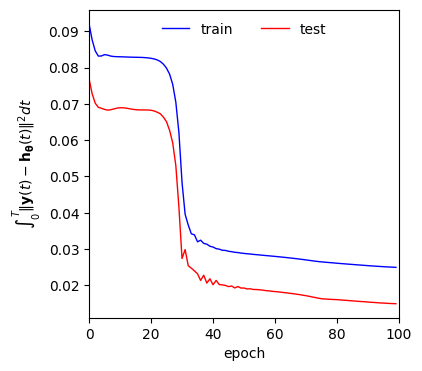

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(train_loss_hist,
            color='b',
            linewidth=1,
            label=r"train")
ax.plot(test_loss_hist,
            color='r',
            linewidth=1,
            label=r"test")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$\int_{0}^T\Vert \mathbf{y}(t)-\mathbf{h}_{\mathbf{\theta}}(t) \Vert^2 dt$")
ax.set_xlim(0,n_e)
# ax.set_ylim(1e-6,1e0)
ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.0),ncol=2,)
fig.savefig("mse_fx_compare.png", dpi=300, bbox_inches="tight")

## - Step 6 **[TODO]**: compare the $\mathcal{NN}$ outcome with the dataset for blind prediction. How to improve the $\mathcal{NN}$?

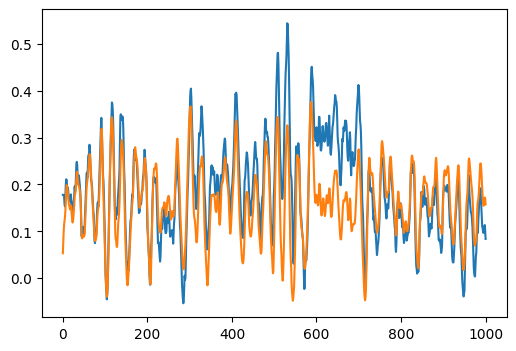

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(y_pred[0,:,0].detach().cpu().numpy())
ax.plot(h_theta(X_pred)[0,:,0].detach().cpu().numpy())